In [1]:
import pandas as pd

import numpy as np

import statistics as stat

import math

In [2]:
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import roc_auc_score,roc_curve


## Multivariate Filter
from sklearn.feature_selection import mutual_info_classif


from sklearn.feature_selection import RFE


## Wrapper Filter 
from sklearn.feature_selection import SequentialFeatureSelector


import matplotlib.pyplot as plt



In [3]:
df=pd.read_csv('cleaned.csv')

## remove rows containing null values

df=df.replace(np.nan,None)
df=df[~df.isnull().all(1)]


x=df.iloc[:,:-1]

x_cols=x.columns

## for x select all columns except the last
X=df.iloc[:,:-1].to_numpy()






## for y select the last
y_df=df.iloc[:,-1]
y=df.iloc[:,-1].to_numpy()



In [4]:
df.head()

,finished_first_q1,finished_first_q2,dif_seconds_quali_first_second,dif_seconds_quali_second_third,dif_seconds_quali_third_fourth,dif_seconds_qualif_fourth_fifth,isAmericas,isAustralia,isEurope,is_reigning_constructor_champion,...,hadRain,avg_temp,avg_humidity,avg_pressure,avg_wind_speed,constructorPositionPreRace,driverPositionPreRace,is_leader_25_percent_through,is_leader_50_percent_through,finishedFirst
0,0,1,0.141,0.366,0.609,0.024,0,0,0,0.0,...,0,87.916667,35.291667,1012.550000,7.833333,1.0,1.0,1,1,0
1,1,1,0.116,0.076,0.564,0.162,0,1,0,0.0,...,0,75.400000,49.168333,1009.616667,13.166667,4.0,4.0,1,0,0
2,0,0,1.346,0.116,0.125,0.087,0,0,0,0.0,...,0,88.100000,67.860000,1007.600000,8.783333,5.0,10.0,0,0,0
3,0,0,0.250,0.105,0.010,0.056,0,0,0,0.0,...,0,67.350000,73.275000,1016.266667,15.633333,3.0,3.0,0,0,0
4,1,1,0.106,0.728,0.108,0.054,0,0,1,0.0,...,0,66.350000,61.245000,1006.733333,8.600000,3.0,8.0,1,1,1


In [52]:
## Check dataset to see if it's imabalanced

df['finishedFirst'].value_counts()

## Dataset is nearly balanced 


finishedFirst
1    151
0    142
Name: count, dtype: int64

In [5]:

## due to differences in data scale we will apply standard scaling.





## Scale only the continuous/d variables as the categorical variables do not need this

X_binary=X[:,[0,1,6,7,8,9,10,12,19,20]]

X_numeric=X[:,[2,3,4,5,11,13,14,15,16,17,18]]

scaler=StandardScaler()

scaler.fit(X_numeric)

X_discrete=X[:,[0,1,6,7,8,9,10,12,17,18]] 

X_continuous_scaled=scaler.transform(X_numeric)

X_binary_cols=x.columns[[0,1,6,7,8,9,10,12,19,20]].tolist()
X_numeric_cols=x.columns[[2,3,4,5,11,13,14,15,16,17,18]].tolist()



X_scaled=np.concatenate([X_numeric,X_binary],axis=1)


data_out=pd.DataFrame(X_scaled,columns=(X_numeric_cols+X_binary_cols))
data_out['finishedFirst']=y



def toStr(val):
    if val==1:
        return 'y'
    if val==0:
        return 'n'

data_out['finishedFirst']=data_out['finishedFirst'].apply(lambda x: toStr(x))




data_out.to_csv('dataset_scaled.csv',index=False)





from sklearn.model_selection import train_test_split


subset=df.sample(frac=.8,axis=0)

subset=subset.reset_index(drop=True)


numeric_features=subset.iloc[:,0:9] 

categorical_features=subset.iloc[:,9:-1]

target=subset.iloc[:,-1]

## Apply univariate filtering 

## we have 21 total features, 9 are numeric, 12 are categorical (binary)

## we will choose 9 features, 5 from categorical and 4 from numeric



### Univariate Filter
from sklearn.feature_selection import SelectKBest, f_regression, chi2 # f_regression for continuous, chi2 for 



chi2_selector = SelectKBest(chi2, k='all')  # Select all features initially to get their scores
chi2_selector.fit(categorical_features, target)
chi2_scores = chi2_selector.scores_

anova_selector = SelectKBest(f_regression, k='all')  # Using F-test for continuous features
anova_selector.fit(numeric_features, target)
anova_scores = anova_selector.scores_


all_feature_scores = pd.DataFrame({
    'Feature': np.concatenate([categorical_features.columns, numeric_features.columns]),
    'Score': np.concatenate([chi2_scores, anova_scores])
    })

all_feature_scores['Category']=['Categorical','Categorical','Categorical','Categorical',
                                'Categorical','Categorical','Categorical','Categorical',
                                'Categorical','Categorical','Categorical','Categorical',
                                'Numeric','Numeric','Numeric','Numeric','Numeric','Numeric','Numeric',
                                'Numeric','Numeric']


## We will select all features and later apply the filter

k = 21
top_k_features = all_feature_scores.nlargest(k, 'Score')



X_categorical_features=all_feature_scores[all_feature_scores.Category == 'Categorical'].nlargest(5, 'Score')['Feature']
X_numeric_features=all_feature_scores[all_feature_scores.Category == 'Numeric'].nlargest(4, 'Score')['Feature']


top_x_cols=[]


for a_col in X_categorical_features.tolist():
    top_x_cols.append(a_col)

for a_col in X_numeric_features.tolist():
    top_x_cols.append(a_col)


X_kbest=df.loc[:,top_x_cols].to_numpy()



scalerKBest=StandardScaler()

scalerKBest.fit(X_kbest)


X_kbest_scaled=scalerKBest.transform(X_kbest)


# Multivariate Filter (Correlation feature selection wrapper in Weka

## output returned just 5 columns 8,10,12,16,19,20 so we select those

X_corr_fs_scaled=X_scaled[:,[8,12,16,19,20]]


## initialize a df to save our model results
model_results=pd.DataFrame()


X_lib={'all_features':X_scaled,'univariate_filter':X_kbest_scaled,'multivariate':X_corr_fs_scaled,'wrapper':X_scaled}
    


print(len(X_scaled))

print(top_x_cols)

293
['driverAge', 'is_leader_50_percent_through', 'is_leader_25_percent_through', 'driverPositionPreRace', 'is_reigning_constructor_champion', 'finished_first_q2', 'dif_seconds_quali_first_second', 'finished_first_q1', 'isAmericas']


variables method: all_features
Grid Search
Cross Validation
[[12 20]
 [ 7 20]]
[[22  5]
 [24  8]]
[[18  8]
 [31  2]]
[[13 18]
 [17 10]]
[[ 3 23]
 [ 2 30]]
variables method: univariate_filter
Grid Search
Cross Validation
[[23  9]
 [ 9 18]]
[[21  6]
 [ 3 29]]
[[21  5]
 [ 7 26]]
[[20 11]
 [ 5 22]]
[[22  4]
 [ 4 28]]
variables method: multivariate
Grid Search
Cross Validation
[[21 11]
 [ 6 21]]
[[24  3]
 [ 7 25]]
[[19  7]
 [ 5 28]]
[[21 10]
 [ 5 22]]
[[22  4]
 [ 5 27]]
variables method: wrapper
Grid Search
Cross Validation
[[24  8]
 [ 5 22]]
[[20  7]
 [ 2 30]]
[[21  5]
 [ 6 27]]
[[21 10]
 [ 4 23]]
[[24  2]
 [ 2 30]]


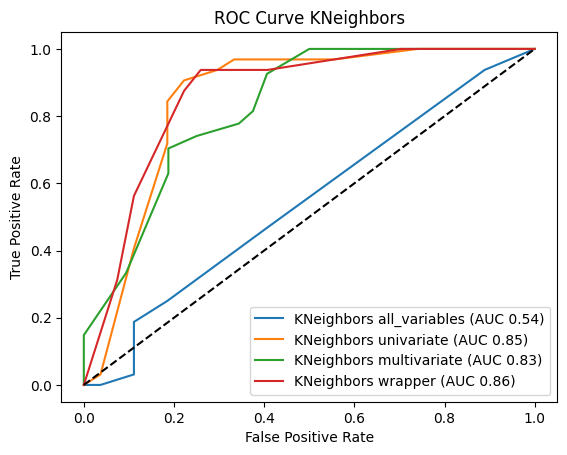

In [ ]:
### K-Nearest Neighbors 
from sklearn.metrics import confusion_matrix







from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score




model=KNeighborsClassifier()

aucs_=[]
tprs_=[]
fprs_=[]


for a_set in X_lib.keys():

  


    X_vars=X_lib[a_set]

    variables=a_set

    print('variables method: '+variables)

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)
 

    if variables=='wrapper':
        
    
        # Apply Forward Selection with 9 variables
        selector = SequentialFeatureSelector(estimator=model, n_features_to_select=7, direction='forward')

        selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()

        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]


        X_vars=X_vars[:,selected_indices]

        # print(np.shape(X_vars))
    
   
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


     ## use gridsearch 
    
    grid ={"n_neighbors":np.arange(1,20)}
    model= KNeighborsClassifier()


   
    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=5,n_jobs=-1) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]

    aucs=[]
    tprs=[]
    fprs=[]

    n_tps=0
    n_tns=0

    
    n_fps=0
    

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter
   
    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))
        
        model=KNeighborsClassifier(n_neighbors=gs_cv.best_params_['n_neighbors'])

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[1,0]
        fn=C[0,1]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 

        
        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

    

        counter+=1



    med_auc_idx=aucs.index(stat.median(aucs))

    fprs_.append(fprs[med_auc_idx])
    tprs_.append(tprs[med_auc_idx])
    aucs_.append(aucs[med_auc_idx])







    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['K Means'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_min_accuracy],
                               'cv_mean_accuracy':[kfold_min_accuracy],
                               'cv_min_recall':[kfold_min_recall],
                               'cv_max_recall':[kfold_max_recall],
                               'cv_mean_recall':[kfold_mean_recall],                   
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns],
                               'cv_mean_auc':[kfold_mean_auc],
                               'cv_min_auc':[kfold_min_auc],
                               'cv_max_auc':[kfold_max_auc]
                               })
    model_results=pd.concat([model_results,temp_results])


## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"KNeighbors "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve KNeighbors")
plt.legend(loc="best")
# plt.show()

plt.savefig('AUC_comparison_KNeighbors.png')


In [55]:
print(roc_auc_score(y_test,y_prob))

0.9338942307692307


variables method: all_features
Grid Search
Fitting 5 folds for each of 36 candidates, totalling 180 fits
kernel: sigmoid
Cross Validation
variables method: univariate_filter
Grid Search
Fitting 5 folds for each of 36 candidates, totalling 180 fits
kernel: sigmoid
Cross Validation
variables method: multivariate
Grid Search
Fitting 5 folds for each of 36 candidates, totalling 180 fits
kernel: rbf
Cross Validation
variables method: wrapper
Grid Search
Fitting 5 folds for each of 36 candidates, totalling 180 fits
kernel: rbf
Cross Validation


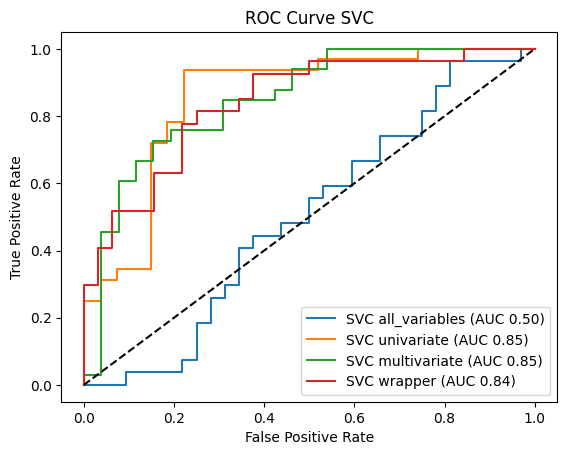

In [56]:
### SVC
from sklearn.metrics import confusion_matrix





from sklearn.model_selection import cross_val_score

from sklearn import svm




model=svm.SVC()

aucs_=[]
tprs_=[]
fprs_=[]



for a_set in X_lib.keys():

    X_vars=X_lib[a_set]

    variables=a_set

    print('variables method: '+variables)


    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


    if variables=='wrapper':
        
    
        # Apply Forward Selection with 8 variables
        selector = SequentialFeatureSelector(estimator=model, n_features_to_select=7, direction='forward')

        selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()

        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]


        X_vars=X_vars[:,selected_indices]

        # print(np.shape(X_vars))
    
   
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


     ## use gridsearch 
    
    model= svm.SVC()



    grid ={"kernel":[ 'rbf','sigmoid' ],
        'C': [0.1, .2, .5, .7, 1, 2, 3, 4,5],
        'gamma': ['scale', 'auto']}
   
    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=5,n_jobs=-1,verbose=2) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]
    aucs=[]

    fprs=[]
    tprs=[]
    

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter
   
    print('kernel: '+gs_cv.best_params_['kernel'])
    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))
        
        model=svm.SVC(probability=True,C=gs_cv.best_params_['C'],kernel=gs_cv.best_params_['kernel'],gamma=gs_cv.best_params_['gamma'])

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        # print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[1,0]
        fn=C[0,1]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 

        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

        

        counter+=1


    med_auc_idx=aucs.index(stat.median(aucs))

    fprs_.append(fprs[med_auc_idx])
    tprs_.append(tprs[med_auc_idx])
    aucs_.append(aucs[med_auc_idx])

    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['SVC'],
                                'variable_method':[variables],
                                'hyper_parameters':[gs_cv.best_params_],
                                'cv_min_accuracy':[kfold_min_accuracy],
                                'cv_max_accuracy':[kfold_min_accuracy],
                                'cv_mean_accuracy':[kfold_min_accuracy],
                                'cv_min_recall':[kfold_min_recall],
                                'cv_max_recall':[kfold_max_recall],
                                'cv_mean_recall':[kfold_mean_recall],                   
                                'cv_min_precision':[kfold_min_precision],
                                'cv_max_precision':[kfold_max_precision],
                                'cv_mean_precision':[kfold_mean_precision],
                                'cv_min_f1':[kfold_min_f1],
                                'cv_max_f1':[kfold_max_f1],
                                'cv_mean_f1':[kfold_mean_f1],
                                'cv_mean_tps':[kfold_mean_tps],
                                'cv_mean_tns':[kfold_mean_tns],
                                'cv_mean_fps':[kfold_mean_fps],
                                'cv_mean_fns':[kfold_mean_fns],
                                'cv_mean_auc':[kfold_mean_auc],
                                'cv_min_auc':[kfold_min_auc],
                                'cv_max_auc':[kfold_max_auc]
                                })
    model_results=pd.concat([model_results,temp_results])



## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"SVC "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve SVC")
plt.legend(loc="best")
# plt.show()


plt.savefig('AUC_comparison_SVC.png')




variables method: all_features
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Cross Validation
[[23  9]
 [ 6 21]]
[[24  3]
 [21 11]]
[[22  4]
 [ 9 24]]
[[14 17]
 [ 5 22]]
[[23  3]
 [ 2 30]]
0.7303754266211604
0.4953271028037383
0.7464788732394366
variables method: univariate_filter
Grid Search
Cross Validation
[[23  9]
 [ 6 21]]
[[21  6]
 [ 4 28]]
[[22  4]
 [ 9 24]]
[[18 13]
 [ 4 23]]
[[22  4]
 [ 3 29]]
0.78839590443686
0.4588744588744589
0.7464788732394366
variables method: multivariate
Grid Search
Cross Validation
[[24  8]
 [ 6 21]]
[[21  6]
 [ 2 30]]
[[22  4]
 [ 9 24]]
[[20 11]
 [ 4 23]]
[[21  5]
 [ 3 29]]
0.8020477815699659
0.4595744680851064
0.7605633802816901
variables method: wrapper
Grid Search
Cross Validation
[[24  8]
 [ 6 21]]
[[21  6]
 [ 4 28]]
[[22  4]
 [ 9 24]]
[[23  8]
 [ 4 23]]
[[23  3]
 [ 2 30]]
0.8156996587030717
0.47280334728033474
0.795774647887324


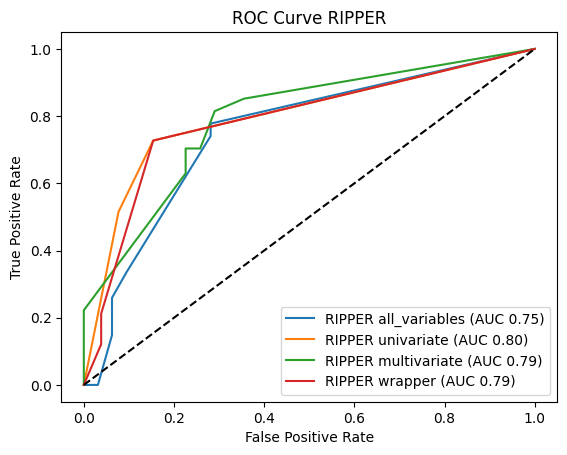

In [57]:
### RIPPER

import  wittgenstein as  lw
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier





from sklearn.model_selection import cross_val_score

aucs_=[]
tprs_=[]
fprs_=[]

model=lw.RIPPER()

for a_set in X_lib.keys():

    X_vars=X_lib[a_set]

    variables=a_set

    print('variables method: '+variables)

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)

    

    if variables=='wrapper':
        
    
        # Apply Forward Selection with 8 variables
        selector = SequentialFeatureSelector(estimator=model, n_features_to_select=7, direction='forward')

        selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()

        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]


        X_vars=X_vars[:,selected_indices]

        # print(np.shape(X_vars))
    
   
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


    ## use gridsearch 
    
    model=lw.RIPPER()

    grid={"prune_size": [.2, 0.33, .4,0.5], "k": [1, 2,3,4,5,6,7,8,9,10],
          'n_discretize_bins':np.arange(5,15)}
   
    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=5,n_jobs=-1) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]
    aucs=[]

    fprs=[]
    tprs=[]

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter
   
    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))
        
        model=lw.RIPPER(n_discretize_bins=gs_cv.best_params_['n_discretize_bins'],
                              k=gs_cv.best_params_['k'],
                              prune_size=gs_cv.best_params_['prune_size'])

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[1,0]
        fn=C[0,1]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 
        
        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

  

        counter+=1


    med_auc_idx=aucs.index(stat.median(aucs))

    fprs_.append(fprs[med_auc_idx])
    tprs_.append(tprs[med_auc_idx])
    aucs_.append(aucs[med_auc_idx])



    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)

    kfold_total_tps=np.sum(tps)
    kfold_total_tns=np.sum(tns)
    kfold_total_fns=np.sum(fns)
    kfold_total_fps=np.sum(fps)

    kfold_total_precision=kfold_total_tps/(kfold_total_tps+kfold_total_tns)

    kfold_total_recall=kfold_total_tps/(kfold_total_tps+kfold_total_fns)

    kfold_total_accuracy=(kfold_total_tns+kfold_total_tps)/(kfold_total_tns+kfold_total_tps+kfold_total_fps+kfold_total_fns)

    temp_results=pd.DataFrame({'algorithm':['RIPPER'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_min_accuracy],
                               'cv_mean_accuracy':[kfold_min_accuracy],
                               'cv_min_recall':[kfold_min_recall],
                               'cv_max_recall':[kfold_max_recall],
                               'cv_mean_recall':[kfold_mean_recall],                   
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns],
                               'cv_mean_auc':[kfold_mean_auc],
                               'cv_min_auc':[kfold_min_auc],
                               'cv_max_auc':[kfold_max_auc]
                               })
    model_results=pd.concat([model_results,temp_results])

    print(kfold_total_accuracy)
    print(kfold_total_precision)
    print(kfold_total_recall)

## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"RIPPER "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve RIPPER")
plt.legend(loc="best")
# plt.show()


plt.savefig('AUC_comparison_RIPPER.png')




variables method: all_features
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2940 fits failed out of a total of 26460.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2940 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\

Cross Validation
variables method: univariate_filter
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2940 fits failed out of a total of 26460.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2940 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\

Cross Validation
variables method: multivariate
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2940 fits failed out of a total of 26460.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2940 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\

Cross Validation
variables method: wrapper
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2940 fits failed out of a total of 26460.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2940 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\

Cross Validation


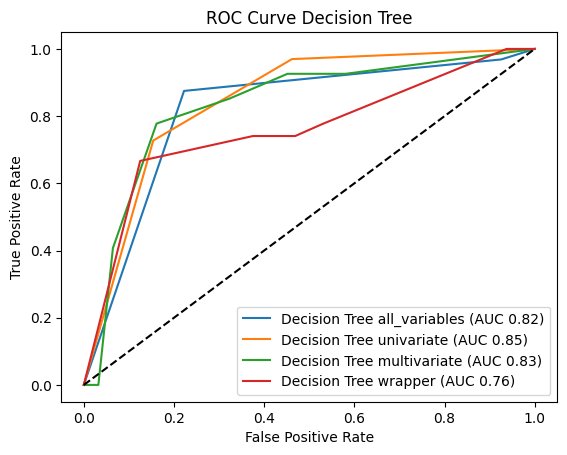

In [58]:
### Decision Tree
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier





from sklearn.model_selection import cross_val_score

aucs_=[]
tprs_=[]
fprs_=[]

model=DecisionTreeClassifier()

for a_set in X_lib.keys():

    X_vars=X_lib[a_set]

    variables=a_set

    print('variables method: '+variables)

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)

    

    if variables=='wrapper':
        
    
        # Apply Forward Selection with 8 variables
        selector = SequentialFeatureSelector(estimator=model, n_features_to_select=7, direction='forward')

        selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()

        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]


        X_vars=X_vars[:,selected_indices]

        # print(np.shape(X_vars))
    
   
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


    ## use gridsearch 
    
    model= DecisionTreeClassifier()

    grid ={"criterion":['gini', 'entropy', 'log_loss' ],
            'max_features': np.arange(1,15),
            'max_depth': np.arange(1,15),
            'min_samples_split':np.arange(1,10)
            }
   
    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=5,n_jobs=-1) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]
    aucs=[]

    fprs=[]
    tprs=[]

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter
   
    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))
        
        model=DecisionTreeClassifier(criterion=gs_cv.best_params_['criterion'],
                                     max_features=gs_cv.best_params_['max_features'],
                                     max_depth=gs_cv.best_params_['max_depth'],
                                     min_samples_split=gs_cv.best_params_['min_samples_split']
                                     )

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        # print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[1,0]
        fn=C[0,1]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 
        
        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

  

        counter+=1


    med_auc_idx=aucs.index(stat.median(aucs))

    fprs_.append(fprs[med_auc_idx])
    tprs_.append(tprs[med_auc_idx])
    aucs_.append(aucs[med_auc_idx])



    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['Decision Tree'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_min_accuracy],
                               'cv_mean_accuracy':[kfold_min_accuracy],
                               'cv_min_recall':[kfold_min_recall],
                               'cv_max_recall':[kfold_max_recall],
                               'cv_mean_recall':[kfold_mean_recall],                   
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns],
                               'cv_mean_auc':[kfold_mean_auc],
                               'cv_min_auc':[kfold_min_auc],
                               'cv_max_auc':[kfold_max_auc]
                               })
    model_results=pd.concat([model_results,temp_results])


## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"Decision Tree "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Decision Tree")
plt.legend(loc="best")
# plt.show()


plt.savefig('AUC_comparison_Decision_Tree.png')




variables method: all_features
<class 'scikeras.wrappers.KerasClassifier'>
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Cross Validation
Fold #1
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/10


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.4261 - loss: 285.0109
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4823 - loss: 29.2678 
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.5185 - loss: 25.9400
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.5357 - loss: 25.4872
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.5156 - loss: 28.6724
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.4509 - loss: 21.4975
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.5382 - loss: 21.8874
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.4705 - loss: 30.2525
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.4953 - loss: 26.7438
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.4770 - loss: 25.0825
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
[[32  0]
 [27  0]]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
Fold 

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.5305 - loss: 44.9583 
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.6147 - loss: 4.0476
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.5634 - loss: 3.8857
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.4236 - loss: 6.6137
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.4779 - loss: 5.2139
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.4831 - loss: 5.0150
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.4493 - loss: 5.6979
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.5605 - loss: 4.4456
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.4986 - loss: 4.6310
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4835 - loss: 5.2135 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
[[26  1]
 [27  5]]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold #3
<class 

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.4824 - loss: 1507.0848
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.4874 - loss: 766.2385
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.5176 - loss: 314.4999
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.5481 - loss: 12.2359
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.4764 - loss: 13.7769
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.4558 - loss: 16.7963
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.4747 - loss: 14.1691
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.4953 - loss: 12.9877
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.5187 - loss: 9.1279
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.4503 - loss: 15.2228
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
[[ 0 26]
 [ 0 33]]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fol

C:\Users\melli\AppData\Local\Temp\ipykernel_22436\1816554466.py:180: RuntimeWarning: invalid value encountered in scalar divide
  precision=tp/(tp+fp)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.4675 - loss: 708.6543 
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.5071 - loss: 19.6401
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.5258 - loss: 21.3239
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.4908 - loss: 32.0040
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.4251 - loss: 30.7933
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.4988 - loss: 20.5027
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.5488 - loss: 14.4024
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.4904 - loss: 33.0389
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.5305 - loss: 26.5785
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.5312 - loss: 22.0076
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
[[18 13]
 [17 10]]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.5219 - loss: 701.4457
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.5062 - loss: 300.5952
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.4507 - loss: 40.6604
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.5217 - loss: 8.3111
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.4935 - loss: 11.0010
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.5427 - loss: 6.3304
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.5093 - loss: 7.5501
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.5326 - loss: 7.6557
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.5163 - loss: 8.4888
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.5433 - loss: 6.1915
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[[ 0 26]
 [ 0 32]]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
variables 

C:\Users\melli\AppData\Local\Temp\ipykernel_22436\1816554466.py:180: RuntimeWarning: invalid value encountered in scalar divide
  precision=tp/(tp+fp)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Cross Validation
Fold #1
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/10


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step - accuracy: 0.5576 - loss: 0.6924
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.6692 - loss: 0.6430
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.7390 - loss: 0.6006
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.7652 - loss: 0.5605
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.7913 - loss: 0.5186
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.8058 - loss: 0.4790
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.7516 - loss: 0.5028
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.8246 - loss: 0.4496
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.8213 - loss: 0.4087
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.7528 - loss: 0.5054
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
[[24  8]
 [ 7 20]]
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
Fold #2
<

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5587 - loss: 0.6811  
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6107 - loss: 0.6551
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7091 - loss: 0.6121  
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7539 - loss: 0.6251
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8176 - loss: 0.5423
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8138 - loss: 0.5525
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7925 - loss: 0.5136
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.7875 - loss: 0.5089
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.8060 - loss: 0.5140
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8049 - loss: 0.4826
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
[[21  6]
 [ 6 26]]
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
Fold #3
<class 'scike

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 0.6767 - loss: 0.6716 
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6342 - loss: 0.6506  
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.7306 - loss: 0.5740
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.7567 - loss: 0.5468
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.8089 - loss: 0.4825
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.8184 - loss: 0.4746
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.8204 - loss: 0.4422
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.8206 - loss: 0.4496
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.8284 - loss: 0.4482
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8354 - loss: 0.4047  
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
[[20  6]
 [ 5 28]]
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold #4
<

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - accuracy: 0.3763 - loss: 0.7512
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5322 - loss: 0.6810
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.7025 - loss: 0.6651
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.8215 - loss: 0.6232
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.8199 - loss: 0.5662
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.8102 - loss: 0.5711
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.8098 - loss: 0.5322
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.8444 - loss: 0.4553
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.8668 - loss: 0.4093
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8340 - loss: 0.4555  
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
[[22  9]
 [ 4 23]]
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
Fold #5
<cl

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step - accuracy: 0.5691 - loss: 0.6869
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.7294 - loss: 0.6201
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.7471 - loss: 0.5839
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.7694 - loss: 0.5280
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.7847 - loss: 0.5169
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7626 - loss: 0.4913
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.7877 - loss: 0.4790
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.7932 - loss: 0.4355
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.8438 - loss: 0.4063
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.8038 - loss: 0.4717
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
[[21  5]
 [ 3 29]]
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
variables m

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Cross Validation
Fold #1
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/300


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4755 - loss: 0.6924  
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4795 - loss: 0.6887 
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5058 - loss: 0.6826 
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5126 - loss: 0.6824 
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5266 - loss: 0.6856 
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5092 - loss: 0.6810 
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5602 - loss: 0.6739 
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5490 - loss: 0.6753 
Epoch 9/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6372 - loss: 0.6718 
Epoch 10/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5904 - loss: 0.6654 
Epoch 11/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6193 - loss: 0.6687 
Epoch 12/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6482 - loss: 0.6569 


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4877 - loss: 0.9376  
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4810 - loss: 0.8412 
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5221 - loss: 0.7821 
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4627 - loss: 0.8080 
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5002 - loss: 0.7653 
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5179 - loss: 0.7477 
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5007 - loss: 0.7479 
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5023 - loss: 0.7352 
Epoch 9/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4940 - loss: 0.7364 
Epoch 10/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5013 - loss: 0.7336 
Epoch 11/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5080 - loss: 0.7235 
Epoch 12/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5039 - loss: 0.7237 


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4962 - loss: 1.7552  
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4712 - loss: 1.5535 
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4827 - loss: 1.2919 
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4717 - loss: 1.1689 
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5129 - loss: 0.9542 
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4905 - loss: 0.9030 
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4743 - loss: 0.8246 
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5259 - loss: 0.7226 
Epoch 9/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5300 - loss: 0.6851 
Epoch 10/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.5590 - loss: 0.6808
Epoch 11/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6389 - loss: 0.6625 
Epoch 12/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6347 - loss: 0.6624

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4733 - loss: 1.7782  
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4592 - loss: 1.5850 
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4671 - loss: 1.4298 
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4639 - loss: 1.3251 
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4707 - loss: 1.2148 
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4619 - loss: 1.1433 
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4905 - loss: 1.0567 
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4717 - loss: 1.0230 
Epoch 9/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4879 - loss: 0.9447 
Epoch 10/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5009 - loss: 0.8771 
Epoch 11/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4921 - loss: 0.8466 
Epoch 12/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4869 - loss: 0.8234 


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5562 - loss: 0.6718  
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6634 - loss: 0.6619 
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6795 - loss: 0.6585 
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6515 - loss: 0.6632 
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7194 - loss: 0.6512 
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6478 - loss: 0.6621 
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6912 - loss: 0.6518 
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7078 - loss: 0.6426 
Epoch 9/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7023 - loss: 0.6338 
Epoch 10/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7261 - loss: 0.6391 
Epoch 11/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7268 - loss: 0.6338 
Epoch 12/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7506 - loss: 0.6355 


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Cross Validation
Fold #1
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/10


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4669 - loss: 69.0207
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3944 - loss: 2.8432
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4803 - loss: 2.1780
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4819 - loss: 1.7476
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5154 - loss: 1.4192
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5113 - loss: 1.1174
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5242 - loss: 1.0041
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4877 - loss: 0.8456
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5564 - loss: 0.8152
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4903 - loss: 0.7142
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[[ 0 32]
 [ 0 27]]
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold #2
<class 'scikeras.wrappe

C:\Users\melli\AppData\Local\Temp\ipykernel_22436\1816554466.py:180: RuntimeWarning: invalid value encountered in scalar divide
  precision=tp/(tp+fp)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4713 - loss: 5.7405
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5386 - loss: 1.8916
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5519 - loss: 1.3453
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4948 - loss: 1.1414
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4570 - loss: 0.8319   
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4277 - loss: 0.6958
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4273 - loss: 0.6932
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5388 - loss: 0.6931
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5051 - loss: 0.6932
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4639 - loss: 0.6933
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[[ 0 27]
 [ 0 32]]
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold #3
<class 'sc

C:\Users\melli\AppData\Local\Temp\ipykernel_22436\1816554466.py:180: RuntimeWarning: invalid value encountered in scalar divide
  precision=tp/(tp+fp)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5122 - loss: 41.2293 
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5085 - loss: 8.7159 
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4790 - loss: 9.7603    
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5529 - loss: 7.0947
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4626 - loss: 8.4834
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5386 - loss: 6.8131
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5275 - loss: 6.4605
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4646 - loss: 8.5763
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5451 - loss: 6.5366
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4907 - loss: 8.2486
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[[ 0 26]
 [ 0 33]]
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold #4
<class

C:\Users\melli\AppData\Local\Temp\ipykernel_22436\1816554466.py:180: RuntimeWarning: invalid value encountered in scalar divide
  precision=tp/(tp+fp)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5173 - loss: 5.6110
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5030 - loss: 0.6934
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4565 - loss: 0.6935
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5302 - loss: 0.6926
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5390 - loss: 0.6921
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5330 - loss: 0.6922
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5845 - loss: 0.6888
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5756 - loss: 0.6891
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5821 - loss: 0.6883
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5185 - loss: 0.6926
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[[ 0 31]
 [ 0 27]]
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold #5
<class 'scike

C:\Users\melli\AppData\Local\Temp\ipykernel_22436\1816554466.py:180: RuntimeWarning: invalid value encountered in scalar divide
  precision=tp/(tp+fp)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4940 - loss: 212.1566
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4807 - loss: 10.4640
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4792 - loss: 10.4695
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5565 - loss: 8.2152
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4916 - loss: 9.6266
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4700 - loss: 10.1576
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4668 - loss: 11.1466
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5006 - loss: 9.9948 
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4486 - loss: 9.9287     
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4564 - loss: 11.2260
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[[26  0]
 [32  0]]
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


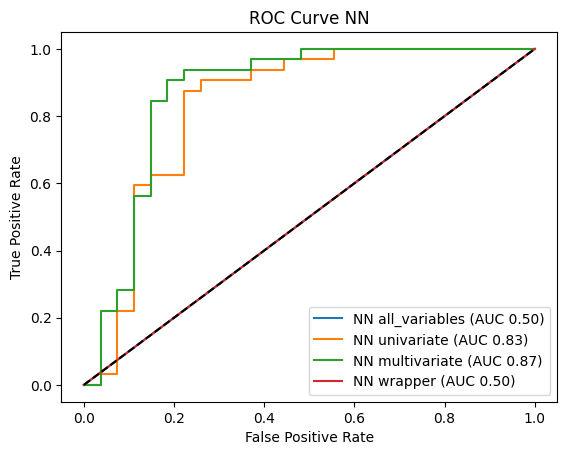

In [59]:
### Neural Network
from sklearn.metrics import confusion_matrix


from scikeras.wrappers import KerasClassifier



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split




aucs_=[]
tprs_=[]
fprs_=[]

model = Sequential()

def createModel(n_of_variables,buildKeras):
    powers_of_two=[4,8,16,32,64]

    a_model=Sequential()
    a_model.add(Dense(units=n_of_variables, activation='relu', input_dim=n_of_variables))

    a_model.add(Dense(units=powers_of_two[2], activation='relu'))

    a_model.add(Dense(units=powers_of_two[1], activation='relu'))

    a_model.add(Dense(units=1, activation='sigmoid'))

    a_model.compile(
                loss='binary_crossentropy',
                metrics=['accuracy']
                )
    
    if buildKeras:
        a_model=KerasClassifier(model=a_model)
    
    return a_model


from sklearn.model_selection import cross_val_score



for a_set in X_lib.keys():


    X_vars=X_lib[a_set]

    n_vars=X_vars.shape[1]

    variables=a_set

    print('variables method: '+variables)


    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)

    
    model=createModel(n_vars,buildKeras=True)

    print(type(model))

    if variables=='wrapper':
        

        ## Weka code using wrapper on MultiLayerPerceptron w greedy stepwise returns variables with index 1,7,9,10

        X_vars=X_vars[:,[4,8,20]]

        # # Apply Forward Selection
        # selector = SequentialFeatureSelector(estimator=model, n_features_to_select=7, direction='forward')

        # selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        # selected_mask = sffs.get_support()

        # Get the indices of the selected features
        # selected_indices = [i for i, x in enumerate(selected_mask) if x]


        # X_vars=X_vars[:,selected_indices]
        
        n_vars=X_vars.shape[1]

        # print(np.shape(X_vars))
    

    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)

    
    ## use gridsearch 
    
    optimizers = [Adam(learning_rate=.001),Adam(learning_rate=.01)]
    # optimizers = ['SGD', 'RMSprop',  'Adam',  'Nadam']
    epoch_options = [10, 50, 100,200,300]
    batch_sizes=[4,16,32,64]
    verbosity=[0]

    model=createModel(n_vars,buildKeras=True)
    
    grid=dict(optimizer=optimizers,epochs=epoch_options,batch_size=batch_sizes,verbose=verbosity)


    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=5,n_jobs=-1) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]
    aucs=[]

    tprs=[]
    fprs=[]

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter

    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        print('Fold #'+str(counter))
        
        model=KerasClassifier(build_fn=createModel(n_vars,buildKeras=False),optimizer=gs_cv.best_params_['optimizer'],
                                    epochs=gs_cv.best_params_['epochs'],
                                    batch_size=gs_cv.best_params_['batch_size'],
                                    )
        print(type(model))

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[1,0]
        fn=C[0,1]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 
        
        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

        counter+=1


    med_auc_idx=aucs.index(stat.median(aucs))

    fprs_.append(fprs[med_auc_idx])
    tprs_.append(tprs[med_auc_idx])
    aucs_.append(aucs[med_auc_idx])



    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['NN'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_min_accuracy],
                               'cv_mean_accuracy':[kfold_min_accuracy],
                               'cv_min_recall':[kfold_min_recall],
                               'cv_max_recall':[kfold_max_recall],
                               'cv_mean_recall':[kfold_mean_recall],                   
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns],
                               'cv_mean_auc':[kfold_mean_auc],
                               'cv_min_auc':[kfold_min_auc],
                               'cv_max_auc':[kfold_max_auc]
                               })
    model_results=pd.concat([model_results,temp_results])




## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"NN "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve NN")
plt.legend(loc="best")
# plt.show()


plt.savefig('AUC_comparison_NN.png')

    



In [60]:
### Rule Induction

# import weka.core.jvm as jvm

# import os
# os.environ["JAVA_HOME"] ='C:/Users/melli/Downloads/openrefine-win-with-java-3.8.2/openrefine-3.8.2/server/target/jre/bin/client'

# print(jvm.started)

# if not jvm.started:
#     jvm.start()

# from weka.classifiers import Classifier
# from weka.core.converters import Loader




# # Load the dataset (ARFF or CSV format)
# loader = Loader(classname="weka.core.converters.ArffLoader")  # Use CSVLoader if CSV
# data = loader.load_file("dataset_scaled.arff")
# data.class_is_last()  # Specify the class attribute

# # Build the PART classifier
# part = Classifier(classname="weka.classifiers.rules.PART")
# part.build_classifier(data)



# jvm.stop()




In [61]:
model_results.to_csv('model_results.csv',index=False)

In [62]:
print(scores)

[0.4576271186440678, 0.5423728813559322, 0.559322033898305, 0.46551724137931033, 0.4482758620689655]
